##  State of the Union Address Sentiment and Linguistic Features Comparison

* Compares sentiment and linguistic features across the latest SOTU address spreech transcript and the last SOTU adresses transcripts of the past 5 presidents.

## Collecting the data

In [1]:
# Obtaining Trump's latest SOTU address, and Obama's, Bush W's, Clinton's, and Bush H.W.'s final SOTU addresses

import urllib2
from BeautifulSoup import BeautifulSoup

speeches = []
titles = []
dates = []

# iterating over the the html page id numbers of the desired speeches
for numb in ('128921', '111174', '76301', '58708', '20544'):
    address = ('http://www.presidency.ucsb.edu/ws/index.php?pid=' + numb)
    html = urllib2.urlopen(address).read()
    soup = BeautifulSoup(html)
    titles.append(soup.find("span", {"class":"paperstitle"}))
    dates.append(soup.find("span", {"class":"docdate"}))
    span = soup.find("span", {"class":"displaytext"})
    # the first paragraf does not have a <p> tag of its own and is embedded in the span tag as a string
    first = span.text
    paras = [p for p in span.findAllNext("p")]
    most_text = "\n\n".join(["".join(p.findAll(text=True)) for p in paras[:-1]])
    # We separte the editorial note from the concluding remarks of the speech in the last paragraph
    last = paras[-1].contents[0]
    text = [first, most_text, last]
    speeches.append("\n\n".join(text))

## Cleaning the data

In [2]:
# Examining the scraped output, we notice that the page containing Clinton's speech is formated slightly differently, 
# with the editor's note included in the penultimate, rather than the last paragraph

# We also note that audience reactions are also included textually in the speech texts
#speeches

In [3]:
# Excluding editor's note from Clinton's address

# The speech texts provide access at the character level, so searching for a unique word will yeild the index of
# its first letter, or for non unique words the index of the first letter in the first appearance of the word
print speeches[3].find("NOTE") # 52548
speeches[3] = speeches[3][:52548]
#speeches[3]

52548


In [4]:
# Excluding audience intervention from Trump's speech

print speeches[0].find("AUDIENCE") # 34272
print speeches[0].find("PRESIDENT") # 34302 marks the letter P, 32313 mark the first letter of the next word "We're"
speeches[0] = speeches[0][:34272] + speeches[0][34313:]
#speeches[0]

-1
-1


In [5]:
# Excluding paranthetical comments about audience reactions from every speech

import re
for i in range(5):
    speeches[i] = re.sub("[\(\[].*?[\)\]]", "", speeches[i])
    
#speeches

## Counting the number of sentences

In [6]:
# Obtaining the number of sentences for each speech
import nltk
n_sent = []
for i in range(5):
    n_sent.append(len(nltk.sent_tokenize(speeches[i])))
    
print n_sent

[390, 359, 309, 495, 320]


## Calculating the SMOG index

In [7]:
# Word tokenize and eliminate punctuation 
tokenizer = nltk.RegexpTokenizer(r'\w+')

w_tok_speeches = []
for i in range(5):
    w_tok_speeches.append(tokenizer.tokenize(speeches[i]))
    
# print w_tok_speeches
# We observe that though the punctuation has been removed, there is an extraneous token 'mdash' that likely comes from
# the html encoding

In [8]:
# Removing the extranous token
for i in range(5):
    w_tok_speeches[i] = filter(lambda w: w not in ['mdash'], w_tok_speeches[i])

In [9]:
# Calculating number of polysyllabic words for each speech
import pyphen
dic = pyphen.Pyphen(lang='en')

count_list = []
polysyllables = []

for i in range(5):
    # Get syllable counts
    count_list.append([len(dic.inserted(x).split('-')) for x in w_tok_speeches[i]])
    # Count number of polysyllabic words
    polysyllables.append(sum(i >= 3 for i in count_list[i]))
    
print polysyllables

[651, 598, 706, 961, 485]


In [10]:
# Calculate the SMOG index for each speech following formula on Wikipedia page https://en.wikipedia.org/wiki/SMOG

# Interestingly, there are no large differences between the speeches, likely reflecting the writen, non-spontaneous, 
# and prepared (perhaps with the help of aids) nature of the texts 
import math

for i in range(5):
    print 1.0430 * math.sqrt(polysyllables[i] * (30.0 / n_sent[i])) + 3.1291

10.5098947196
10.5021690896
11.7642134262
11.0889343557
10.1621032148


## Calculating the average number of words per sentence

In [11]:
sent_tok_speeches = []
word_sent_tok_speeches = []

for i in range(5):
    # Sentence tokenize each text
    sent_tok_speeches.append(nltk.sent_tokenize(speeches[i]))
    # Word tokenize each sentence and remove punctuation
    word_sent_tok_speeches.append([tokenizer.tokenize(x) for x in sent_tok_speeches[i]])


# Remove extraneous mdash token and count number of words in each sentence for each speech
import copy
sent_len = copy.deepcopy(word_sent_tok_speeches)
for i in range(5):
    for j in range(n_sent[i]):
        word_sent_tok_speeches[i][j] = filter(lambda w: w not in ['mdash'], word_sent_tok_speeches[i][j])
        sent_len[i][j] = len(word_sent_tok_speeches[i][j])
    
    
# Calculate average number of words per sentence for each speech      
import numpy as np
for i in range(5):
    print np.mean(sent_len[i])  

15.3
17.445682451253482
18.74433656957929
18.70909090909091
16.303125


## Overall speech sentiment rating 

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Making a copy of the sentiment analyzer with a short name
sid = SentimentIntensityAnalyzer()

totPos = 0.0
totNeg = 0.0

# Looping through the 5 articles
for i in range(5):
    sentRating = sid.polarity_scores(speeches[i])
    totPos += sentRating['pos']
    totNeg += sentRating['neg']
    print(totPos)
    print(totNeg)

    print("===========================================\n")
    
# All articles have higher positive than negative score

0.186
0.11

0.357
0.204

0.569
0.304

0.762
0.373

0.922
0.454



## Per sentence sentiment rating

In [13]:
# Creating empty containers for the five speeches
Pos_sent_scores = [[],[],[],[],[]]
Neg_sent_scores = [[],[],[],[],[]]

for i in range(5):
    # sentence tokenizing speeches
    speechSent = nltk.sent_tokenize(speeches[i])
    # iterating through sentences of a speech
    for sentence in speechSent:
        sentRating = sid.polarity_scores(sentence)
        Pos_sent_scores[i].append(sentRating['pos'])
        Neg_sent_scores[i].append(sentRating['neg'])

# print Pos_sent_scores

# print "\n============================================================================================================\n"

# print Neg_sent_scores

# print "\n============================================================================================================\n"

net_sentiment = [[], [], [], [], []]
for i in range(5):
    for j in range(len(Pos_sent_scores[i])):
               net_sentiment[i].append(Pos_sent_scores[i][j] - Neg_sent_scores[i][j])
print net_sentiment

[[0.0, 0.147, 0.173, 0.28, 0.326, 0.371, 0.098, -0.15399999999999997, 0.0, 0.183, 0.148, 0.055999999999999994, 0.091, 0.03, 0.064, 0.317, 0.385, 0.455, 0.263, 0.0, -0.23300000000000004, 0.135, 0.424, 0.385, 0.804, 0.0, -0.123, 0.385, 0.227, 0.0, 1.0, -0.093, -0.268, 0.0, 0.0, 0.0, 0.714, 0.203, 0.0, 0.0, 0.206, 0.318, 0.28, 0.571, 0.0, 0.0, 0.0, -0.556, -0.096, -0.258, 0.355, 0.207, 0.204, 0.011999999999999997, 0.05199999999999999, -0.136, 0.245, 0.302, -0.1, -0.141, -0.164, -0.358, 0.464, 0.804, 0.057, 0.015, -0.11, 0.206, 0.318, 0.0, 0.815, 0.0, 0.0, -0.09499999999999999, 0.017, 0.535, 0.577, 0.174, 0.677, -0.023999999999999994, 0.0, 0.0, 0.149, 0.0, -0.027999999999999997, -0.047, 0.019000000000000003, 0.053, 0.0, 0.283, 0.0, 0.141, 0.259, 0.458, -0.091, 0.16999999999999998, 0.412, 0.161, 0.166, 0.804, 0.238, 0.455, 0.087, 0.442, 0.244, 0.252, 0.3, 0.391, 0.106, -0.00399999999999999, 0.366, 0.348, 0.472, 0.714, 0.128, 0.0, 0.030999999999999972, 0.375, 0.286, 0.0, 0.135, 0.0, 0.0, 0.0

## Graph showing POS (Part of Speech) Frequency distribution

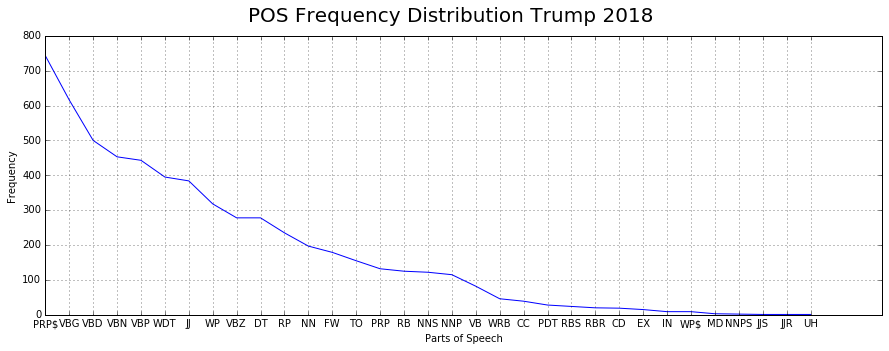

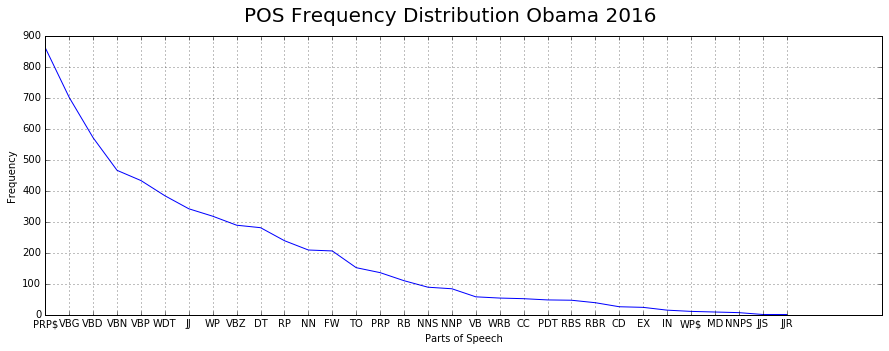

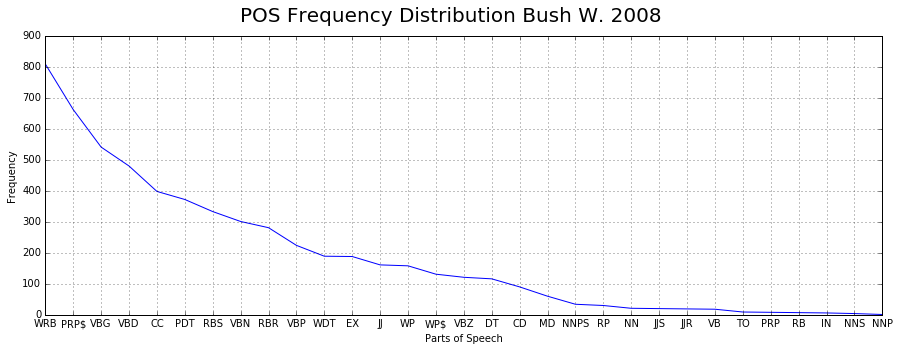

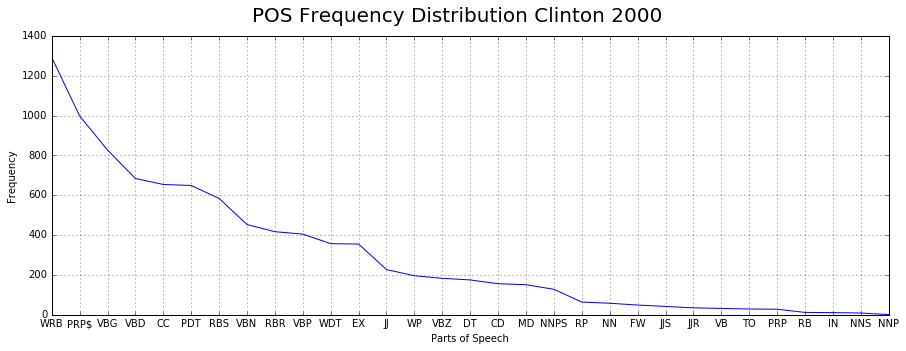

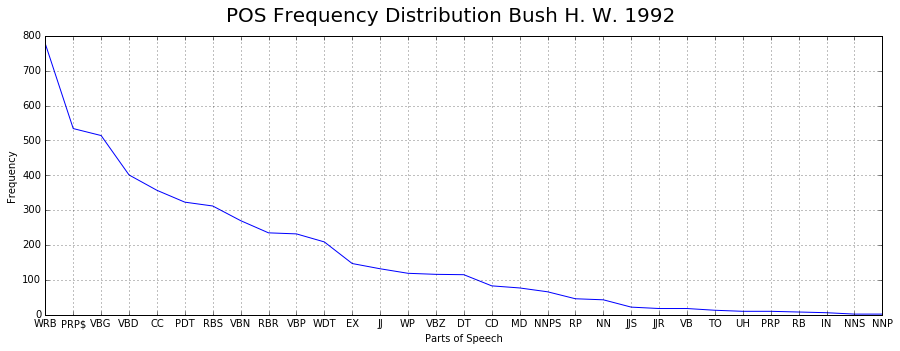

In [14]:
%matplotlib inline
import matplotlib.pylab as plt

speeches_tagged = []
freq_dist_tag = []
titles = ["POS Frequency Distribution Trump 2018", "POS Frequency Distribution Obama 2016", 
          "POS Frequency Distribution Bush W. 2008", "POS Frequency Distribution Clinton 2000",
          "POS Frequency Distribution Bush H. W. 1992"]

for i in range(5):
    # Tagging speeches
    speeches_tagged.append(nltk.pos_tag(w_tok_speeches[i]))
    # Creating frequency distribution dictionaries
    freq_dist_tag.append(dict(nltk.FreqDist(tag for (word, tag) in speeches_tagged[i])))
    # Creating frequency distribution plots
    plt.figure(figsize=(15,5))
    plt.plot(range(len(freq_dist_tag[i])), sorted(freq_dist_tag[i].values(), reverse=True))
    plt.xticks(range(len(freq_dist_tag[i])), list(freq_dist_tag[i].keys()))
    plt.suptitle(titles[i], fontsize=20)
    plt.xlabel("Parts of Speech")
    plt.ylabel("Frequency")
    plt.grid()
    #plt.show()

In [15]:
# The most common part of speech is either possessive pronoun (PRP$) - Trump and Obama speeches or WH-adverb (WRB) - 
# Bush w. Clinton and Bush H.W. speeches. Trump and Obama speeches also use less coordinating conjunctions (CC), 
# predeterminers (PDT) and superlative adverbs than the other three speeches

# nltk.help.upenn_tagset()

## Graph of sentiment rating by sentence (bar or line)

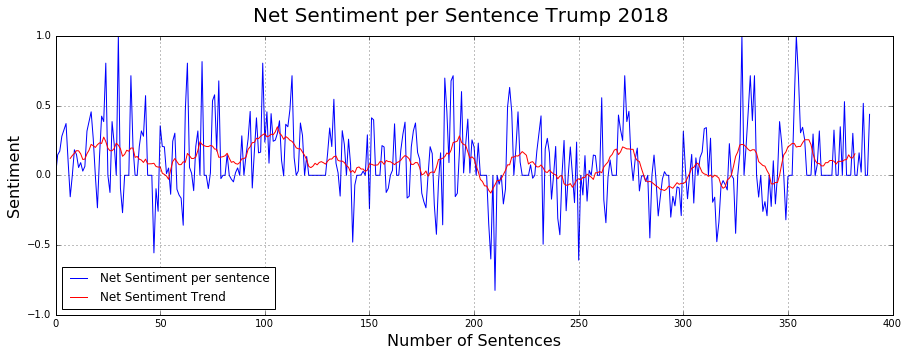

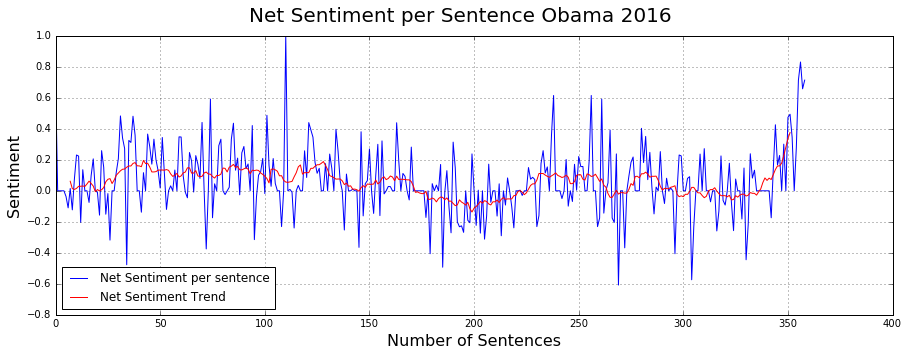

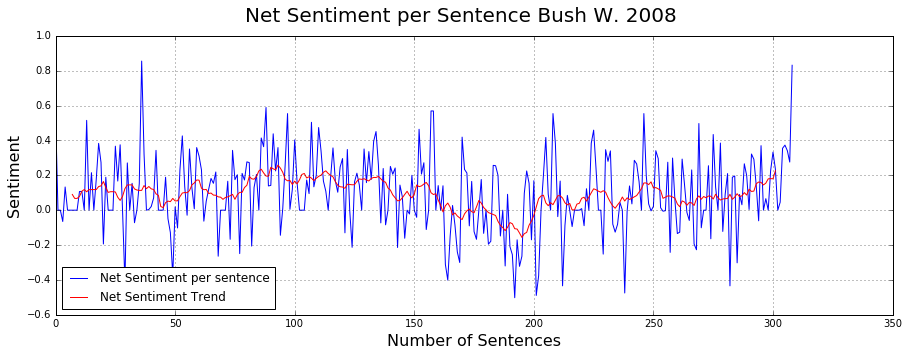

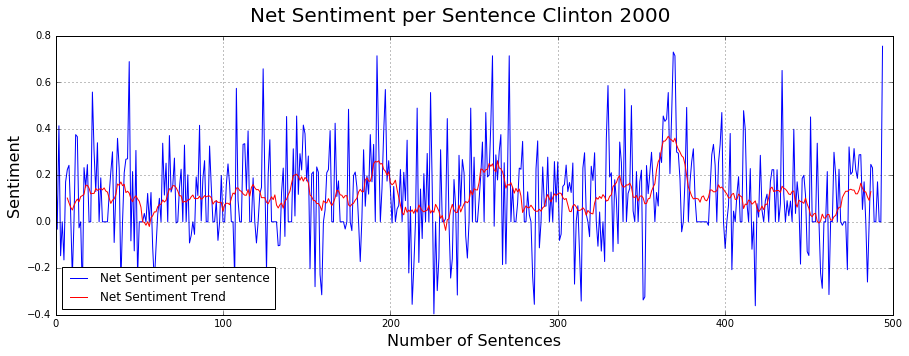

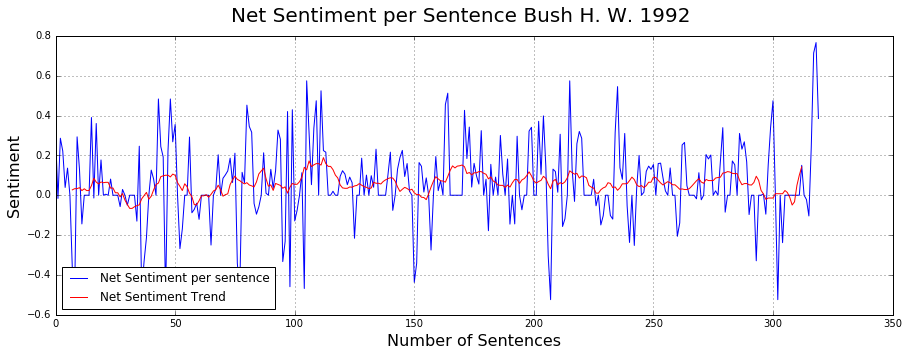

In [16]:
# Plotting net sentiment scores per sentence for each speech with trend line
import pandas as pd

titles = ["Net Sentiment per Sentence Trump 2018", "Net Sentiment per Sentence Obama 2016", 
          "Net Sentiment per Sentence Bush W. 2008", "Net Sentiment per Sentence Clinton 2000", 
          "Net Sentiment per Sentence Bush H. W. 1992"]

for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.plot(range(len(net_sentiment[i])), net_sentiment[i]) 
    # add trend line using a moving average calculated obver 15 sentences at a time
    plt.plot(pd.Series(net_sentiment[i]).rolling(15, center = True).mean( ), color = "red")
    plt.suptitle(titles[i], fontsize=20)
    plt.xlabel("Number of Sentences", fontsize = 16)
    plt.ylabel("Sentiment", fontsize = 16)
    plt.legend(['Net Sentiment per sentence', 'Net Sentiment Trend'], loc='lower left')
    plt.grid()
    #plt.show()

In [17]:
# We notice that among the 5 speeches, Trump's speech has the highest number of very positive peaks, i.e. sentences or
# small grouping of sentences. Whereas all other speeches have peaks that cross the 0.6 level but do not reach 0.8 or
# above, with a single exception in Obama's speech, Trump's speech has 5 peaks that reach the maximum normaized 
# positive score of 1. Looking at the total of number of peaks at or above 0.6, Bush H.W has 1, Bush W. has 2, 
# Obama has 4, Clinton's speech has 8 and Trump has 16!

# Trump also has the highest number of negative numbers of sentences below -0.4, with 12 such lows, compared to 
# Bush H. W.'s 9 and Obama's and Bush W.'s 7.

# In terms of the braoder outline of each speech Trump's, Obama's and Bush W. tennd to have more negative middles 
# sections and more optimistic beginnings and ends, although Trump's middle section apears to have 4 shoorter troughs 
# divided by short positive sections. In contrast, Clinton and Bush H.W. appear to maintain a positive and a 
# neutral/moderately positive tone respectively throughout their speeches.

# Interestingly, the per sentece sentiment analysis seems to be somewhat in conflict with the per speech sentiment 
# analysis where we notice that Trump's speech has both the lowest positive and negative polarity scores